<a href="https://colab.research.google.com/github/uxzh/stock-prediction/blob/main/Copy_of_SNP500_v2_MSENAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download and install TA-Lib from source
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install

# Install the ta-lib Python wrapper
!pip install ta-lib

--2024-07-27 14:38:47--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-07-27 14:38:47--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-07-27 14:38:47--  http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Resolvi

#Import Libraries


In [ ]:
# Install required libraries
!pip install scikeras tensorflow keras==3.4.1 yfinance requests beautifulsoup4 scikit-learn

In [ ]:
!pip install scikeras


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import spearmanr

# Fetch and preprocess data

In [ ]:
def fetch_and_preprocess_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate technical indicators
    data['Returns'] = data['Close'].pct_change()
    data['SMA_20'] = ta.SMA(data['Close'], timeperiod=20)
    data['RSI'] = ta.RSI(data['Close'], timeperiod=14)
    data['MACD'], data['MACD_Signal'], _ = ta.MACD(data['Close'])
    data['ATR'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data['Bollinger_Upper'], data['Bollinger_Middle'], data['Bollinger_Lower'] = ta.BBANDS(data['Close'], timeperiod=20)
    data['OBV'] = ta.OBV(data['Close'], data['Volume'])

    # Drop NaN values and reset index
    data.dropna(inplace=True)
    data.reset_index(inplace=True)

    return data


# Create sequences for LSTM


In [ ]:
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# LSTM Model

In [ ]:
def create_lstm_model(input_shape, units=50, dropout_rate=0.2):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Evaluate model


In [ ]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Calculate Sharpe ratio

In [ ]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate / 252  # Assuming daily returns
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# Simple backtesting

In [ ]:
def backtest(returns):
    cumulative_returns = (1 + returns).cumprod()
    total_return = cumulative_returns.iloc[-1] - 1
    sharpe_ratio = calculate_sharpe_ratio(returns)
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return total_return, sharpe_ratio, max_drawdown

# Main function

[*********************100%%**********************]  1 of 1 completed

Fitting 5 folds for each of 20 candidates, totalling 100 fits



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Random Forest Model:
RandomForestRegressor(min_samples_leaf=2, min_samples_split=5,
                      n_estimators=1000, random_state=42)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0479 - val_loss: 0.0324
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0041 - val_loss: 0.0190
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0031 - val_loss: 0.0213
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0028 - val_loss: 0.0248
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0022 - val_loss: 0.0084
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0021 - val_loss: 0.0173
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0020 - val_loss: 0.0240
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0018 - val_loss: 0.0227
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0016 - val_loss: 0.0195
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0014 - val_loss: 0.0143
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0016 - val_loss: 0.0202
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.

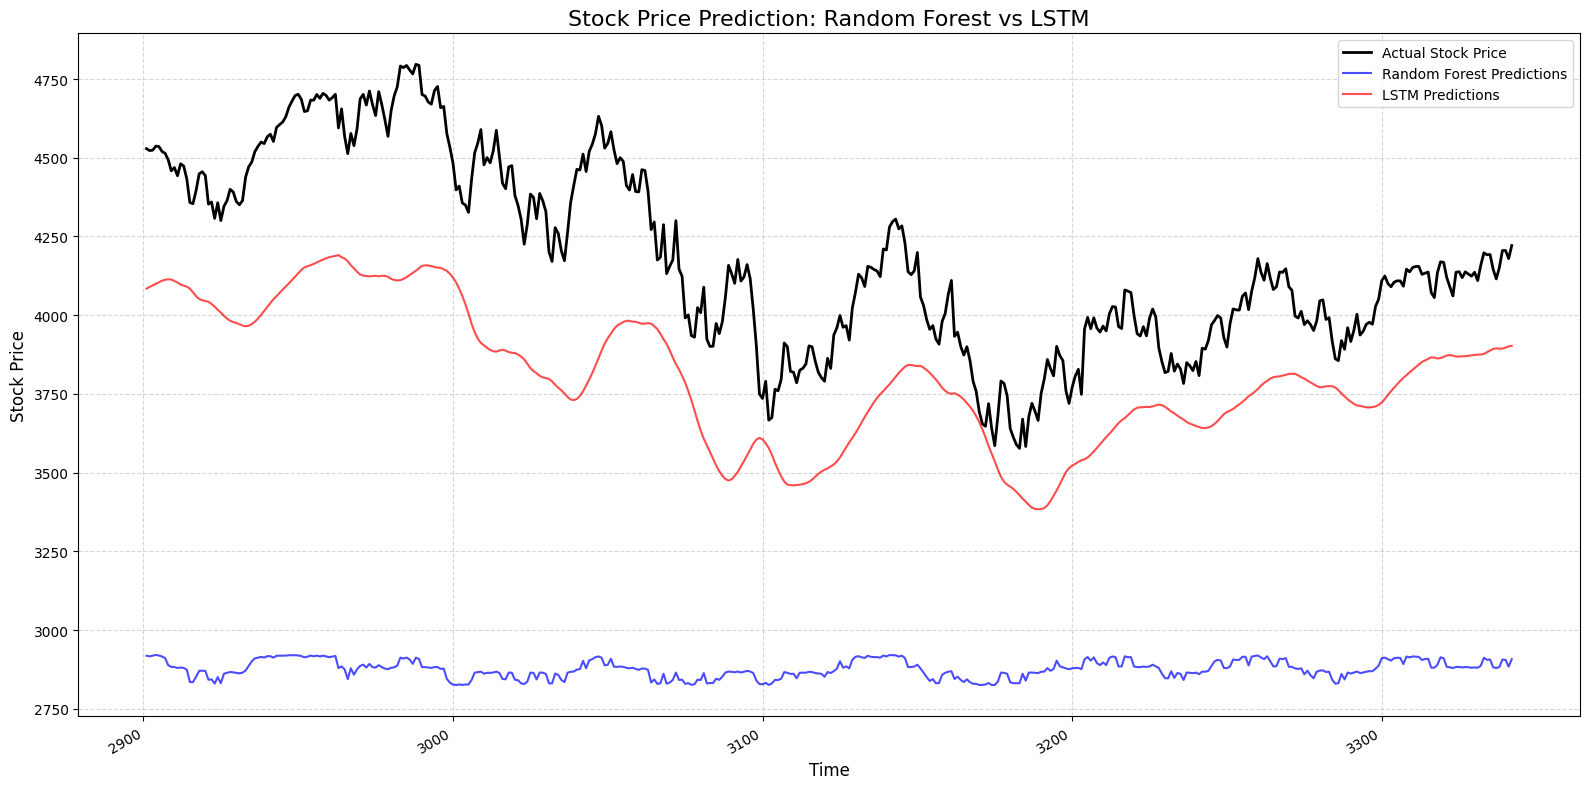

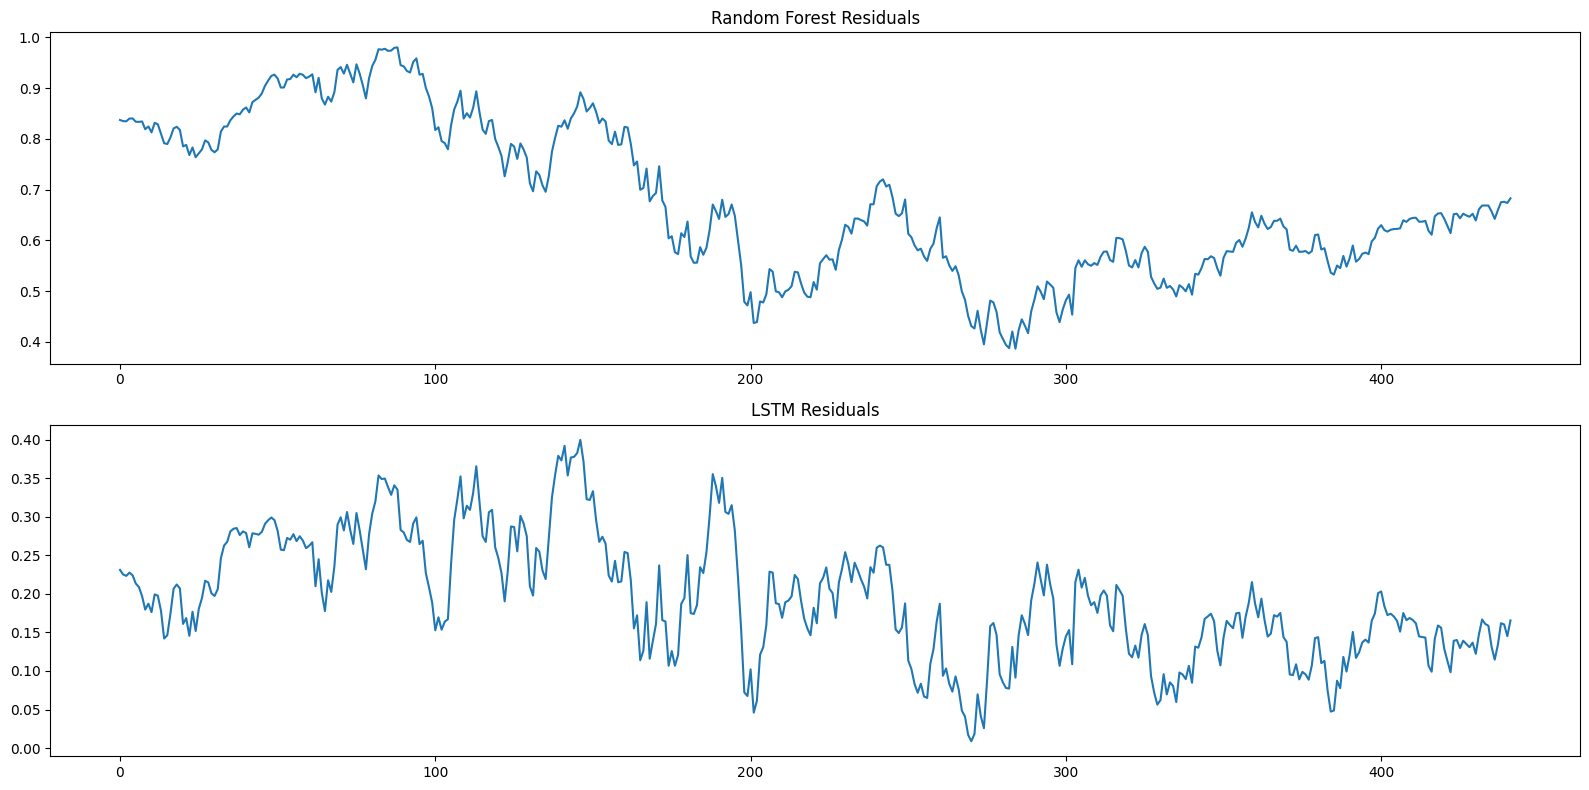

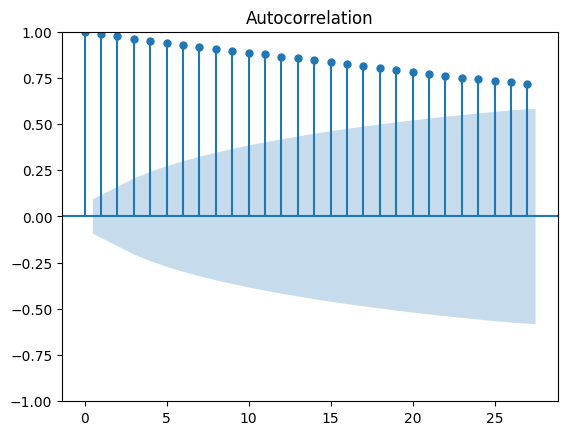

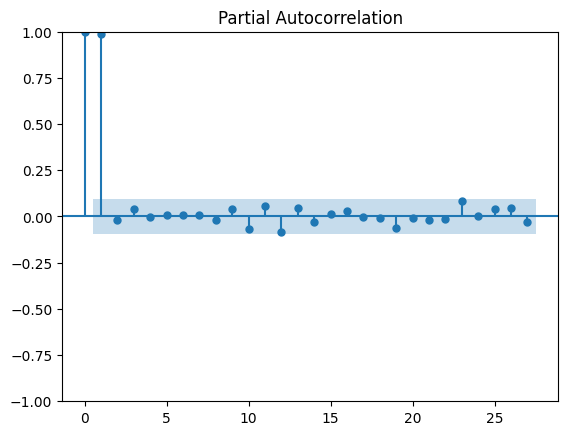

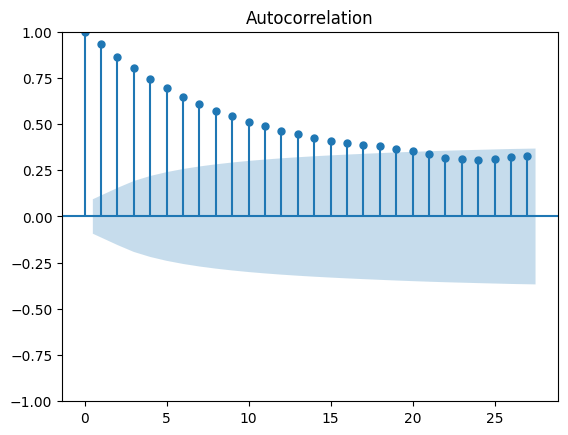

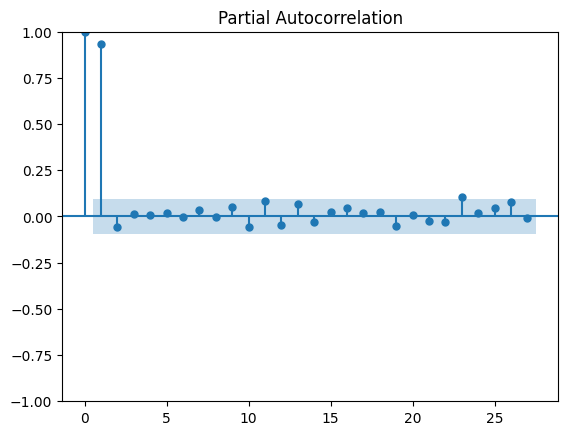

ADF Test for Random Forest Residuals:
ADF Statistic: -1.7594363144990033
p-value: 0.40077814535023965
Critical Values:
	1%: -3.4452655826028318
	5%: -2.868116205869215
	10%: -2.570272878944473

ADF Test for LSTM Residuals:
ADF Statistic: -3.88161845040238
p-value: 0.0021743679152140534
Critical Values:
	1%: -3.4452655826028318
	5%: -2.868116205869215
	10%: -2.570272878944473

Random Forest Spearman's Rank Correlation: 0.4524
LSTM Spearman's Rank Correlation: 0.8878

Backtest Results:
Random Forest:
  Total Return: -0.0037
  Sharpe Ratio: -0.1389
  Max Drawdown: -0.0327
LSTM:
  Total Return: -0.0445
  Sharpe Ratio: -0.7518
  Max Drawdown: -0.1925
Actual:
  Total Return: -0.0639
  Sharpe Ratio: -0.1293
  Max Drawdown: -0.2543


In [ ]:
def main():
    # Fetch and preprocess data
    ticker = '^GSPC'
    start_date = '2010-01-01'
    end_date = '2023-06-02'
    data = fetch_and_preprocess_data(ticker, start_date, end_date)

    # Prepare features and target
    features = ['Returns', 'SMA_20', 'RSI', 'MACD', 'MACD_Signal', 'ATR', 'Bollinger_Upper', 'Bollinger_Lower', 'OBV']
    target = 'Close'

    # Split data
    train_size = int(len(data) * 0.7)
    val_size = int(len(data) * 0.15)
    train_data = data[:train_size]
    val_data = data[train_size:train_size+val_size]
    test_data = data[train_size+val_size:]

    # Prepare data for models
    X_train = train_data[features]
    y_train = train_data[target]
    X_val = val_data[features]
    y_val = val_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Normalize data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Random Forest Model with Hyperparameter Tuning
    rf_param_grid = {
        'n_estimators': [200, 500, 1000],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf_model = RandomForestRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=5)
    rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid,
                                          n_iter=20, cv=tscv, verbose=2, random_state=42, n_jobs=-1)
    rf_random_search.fit(X_train_scaled, y_train_scaled.ravel())
    best_rf_model = rf_random_search.best_estimator_
    print("Best Random Forest Model:")
    print(best_rf_model)

    # LSTM Model
    X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_scaled)
    X_val_lstm, y_val_lstm = create_sequences(X_val_scaled, y_val_scaled)
    X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test_scaled)

    lstm_model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lstm_model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32,
                   validation_data=(X_val_lstm, y_val_lstm), callbacks=[early_stopping])

     # Evaluate models
    rf_predictions = best_rf_model.predict(X_test_scaled)
    lstm_predictions = lstm_model.predict(X_test_lstm).flatten()

    rf_mse, rf_mae, rf_r2 = evaluate_model(y_test_scaled[60:], rf_predictions[60:].reshape(-1, 1))
    lstm_mse, lstm_mae, lstm_r2 = evaluate_model(y_test_scaled[60:], lstm_predictions.reshape(-1, 1))

    # Calculate returns and Sharpe ratios
    rf_returns = pd.Series(scaler_y.inverse_transform(rf_predictions[60:].reshape(-1, 1)).flatten()).pct_change().dropna()
    lstm_returns = pd.Series(scaler_y.inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()).pct_change().dropna()
    actual_returns = test_data['Returns'].iloc[60:]  # Adjust for sequence length

    rf_sharpe = calculate_sharpe_ratio(rf_returns)
    lstm_sharpe = calculate_sharpe_ratio(lstm_returns)
    actual_sharpe = calculate_sharpe_ratio(actual_returns)

    # Print results
    print("\nRandom Forest Performance:")
    print(f"MSE: {rf_mse:.4f}, MAE: {rf_mae:.4f}, R2: {rf_r2:.4f}, Sharpe Ratio: {rf_sharpe:.4f}")
    print("\nLSTM Performance:")
    print(f"MSE: {lstm_mse:.4f}, MAE: {lstm_mae:.4f}, R2: {lstm_r2:.4f}, Sharpe Ratio: {lstm_sharpe:.4f}")
    print(f"\nActual Sharpe Ratio: {actual_sharpe:.4f}")


    # Feature importance for Random Forest
    feature_importance = pd.DataFrame({'feature': features, 'importance': best_rf_model.feature_importances_})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importance)

    # Visualize results
    plt.figure(figsize=(16, 8))
    plt.plot(test_data.index[60:], scaler_y.inverse_transform(y_test_scaled[60:]), label='Actual Stock Price', color='black', linewidth=2)
    plt.plot(test_data.index[60:], scaler_y.inverse_transform(rf_predictions[60:].reshape(-1, 1)), label='Random Forest Predictions', color='blue', alpha=0.7)
    plt.plot(test_data.index[60:], scaler_y.inverse_transform(lstm_predictions.reshape(-1, 1)), label='LSTM Predictions', color='red', alpha=0.7)
    plt.title('Stock Price Prediction: Random Forest vs LSTM', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # Analyze residuals
    rf_residuals = (y_test_scaled[60:] - rf_predictions[60:].reshape(-1, 1)).flatten()
    lstm_residuals = (y_test_lstm - lstm_predictions.reshape(-1, 1)).flatten()

    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    plt.plot(rf_residuals)
    plt.title('Random Forest Residuals')
    plt.subplot(2, 1, 2)
    plt.plot(lstm_residuals)
    plt.title('LSTM Residuals')
    plt.tight_layout()
    plt.show()

    # ACF and PACF of residuals
    plot_acf(rf_residuals)
    plot_pacf(rf_residuals)
    plt.show()

    plot_acf(lstm_residuals)
    plot_pacf(lstm_residuals)
    plt.show()

    # Augmented Dickey-Fuller test for stationarity
    def adf_test(series):
        result = adfuller(series)
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value}')

    print("ADF Test for Random Forest Residuals:")
    adf_test(rf_residuals)
    print("\nADF Test for LSTM Residuals:")
    adf_test(lstm_residuals)

    # Calculate Spearman's rank correlation
    rf_spearman, _ = spearmanr(y_test_scaled, rf_predictions)
    lstm_spearman, _ = spearmanr(y_test_lstm, lstm_predictions)
    print(f"\nRandom Forest Spearman's Rank Correlation: {rf_spearman:.4f}")
    print(f"LSTM Spearman's Rank Correlation: {lstm_spearman:.4f}")

    # Simple backtesting
    def backtest(returns):
        cumulative_returns = (1 + returns).cumprod()
        total_return = cumulative_returns.iloc[-1] - 1
        sharpe_ratio = calculate_sharpe_ratio(returns)
        max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
        return total_return, sharpe_ratio, max_drawdown

    print("\nBacktest Results:")
    for name, returns in [("Random Forest", rf_returns), ("LSTM", lstm_returns), ("Actual", actual_returns)]:
        total_return, sharpe_ratio, max_drawdown = backtest(returns)
        print(f"{name}:")
        print(f"  Total Return: {total_return:.4f}")
        print(f"  Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"  Max Drawdown: {max_drawdown:.4f}")

if __name__ == "__main__":
    main()